# Load data

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

train_dir = '../input/herbarium-2022-fgvc9/train_images/'
test_dir = '../input/herbarium-2022-fgvc9/test_images/'

with open("../input/herbarium-2022-fgvc9/train_metadata.json") as json_file:
    train_meta = json.load(json_file)
with open("../input/herbarium-2022-fgvc9/test_metadata.json") as json_file:
    test_meta = json.load(json_file)

# JSON -> Dataframe

In [3]:
image_ids = [image["image_id"] for image in train_meta["images"]]
image_dirs = [train_dir + image['file_name'] for image in train_meta["images"]]
category_ids = [annotation['category_id'] for annotation in train_meta['annotations']]
genus_ids = [annotation['genus_id'] for annotation in train_meta['annotations']]

test_ids = [image['image_id'] for image in test_meta]
test_dirs = [test_dir + image['file_name'] for image in test_meta]

#Create the initial training dataframe with the above defined columns
train_df = pd.DataFrame({
    "image_id" : image_ids,
    "image_dir" : image_dirs,
    "category" : category_ids,
    "genus" : genus_ids})

#Create a testing dataframe
test_df = pd.DataFrame({
    "test_id" : test_ids,
    "test_dir" : test_dirs
})

# Mapping genus and family

In [4]:
#Add a genus column to the dataframe
genus_map = {genus['genus_id'] : genus['genus'] for genus in train_meta['genera']}
train_df['genus'] = train_df['genus'].map(genus_map)

##Create a family column in the datagframe based on the genus names
    # Step 1: Create dictionary of genus -> family mapping
genus_family_map = {}
for category in train_meta["categories"]:
    genus = category['genus']
    family = category['family']
    genus_family_map[genus] = family

    # Step 2: Create new column with default value of None™
train_df['family'] = None

    # Step 3: Update values in new column based on genus -> family mapping
for i, row in train_df.iterrows():
    genus = row['genus']
    if genus in genus_family_map:
        family = genus_family_map[genus]
        train_df.at[i, 'family'] = family

train_df

,image_id,image_dir,category,genus,family
0,00000__001,../input/herbarium-2022-fgvc9/train_images/000...,0,Abies,Pinaceae
1,00000__002,../input/herbarium-2022-fgvc9/train_images/000...,0,Abies,Pinaceae
2,00000__003,../input/herbarium-2022-fgvc9/train_images/000...,0,Abies,Pinaceae
3,00000__004,../input/herbarium-2022-fgvc9/train_images/000...,0,Abies,Pinaceae
4,00000__005,../input/herbarium-2022-fgvc9/train_images/000...,0,Abies,Pinaceae
...,...,...,...,...,...
839767,15504__032,../input/herbarium-2022-fgvc9/train_images/155...,15504,Zygophyllum,Zygophyllaceae
839768,15504__033,../input/herbarium-2022-fgvc9/train_images/155...,15504,Zygophyllum,Zygophyllaceae
839769,15504__035,../input/herbarium-2022-fgvc9/train_images/155...,15504,Zygophyllum,Zygophyllaceae
839770,15504__036,../input/herbarium-2022-fgvc9/train_images/155...,15504,Zygophyllum,Zygophyllaceae


# Filtering to Poaceae

In [5]:
#Filter only the images of plants that are in the Poaceae family
grass_images = train_df.loc[train_df['family'] == 'Poaceae']
#Reset index
grass_images = grass_images.reset_index(drop=True)
grass_images

,image_id,image_dir,category,genus,family
0,00333__001,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae
1,00333__002,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae
2,00333__003,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae
3,00333__004,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae
4,00333__005,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae
...,...,...,...,...,...
53542,15501__101,../input/herbarium-2022-fgvc9/train_images/155...,15501,Zuloagaea,Poaceae
53543,15501__103,../input/herbarium-2022-fgvc9/train_images/155...,15501,Zuloagaea,Poaceae
53544,15501__105,../input/herbarium-2022-fgvc9/train_images/155...,15501,Zuloagaea,Poaceae
53545,15501__106,../input/herbarium-2022-fgvc9/train_images/155...,15501,Zuloagaea,Poaceae


In [6]:
#Add category_id and species column
grass_images["species"] = None

# Extract category_id and species values from categories where the family is Poaceae
species_list = []
for category in train_meta["categories"]:
    if category["family"] == "Poaceae":
        species_list.append({
            "category": category["category_id"],
            "species": category["species"]
        })

# loop through data frame and species list to update species column
for i, row in grass_images.iterrows():
    for species in species_list:
        if row['category'] == species['category']:
            grass_images.at[i, 'species'] = species['species']
            
grass_images

,image_id,image_dir,category,genus,family,species
0,00333__001,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae,blasdalei
1,00333__002,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae,blasdalei
2,00333__003,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae,blasdalei
3,00333__004,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae,blasdalei
4,00333__005,../input/herbarium-2022-fgvc9/train_images/003...,333,Agrostis,Poaceae,blasdalei
...,...,...,...,...,...,...
53542,15501__101,../input/herbarium-2022-fgvc9/train_images/155...,15501,Zuloagaea,Poaceae,bulbosa
53543,15501__103,../input/herbarium-2022-fgvc9/train_images/155...,15501,Zuloagaea,Poaceae,bulbosa
53544,15501__105,../input/herbarium-2022-fgvc9/train_images/155...,15501,Zuloagaea,Poaceae,bulbosa
53545,15501__106,../input/herbarium-2022-fgvc9/train_images/155...,15501,Zuloagaea,Poaceae,bulbosa


In [7]:
print('Top 15 Genus in Poaceae family')
print(grass_images['genus'].value_counts().head(15))

Top 15 Genus in Poaceae family
Muhlenbergia     4228
Paspalum         3124
Poa              2608
Dichanthelium    2474
Sporobolus       2304
Eragrostis       2068
Aristida         1951
Festuca          1469
Bromus           1458
Bouteloua        1427
Panicum          1415
Setaria          1287
Eriocoma         1244
Elymus           1223
Melica            941
Name: genus, dtype: int64


# Data visualization

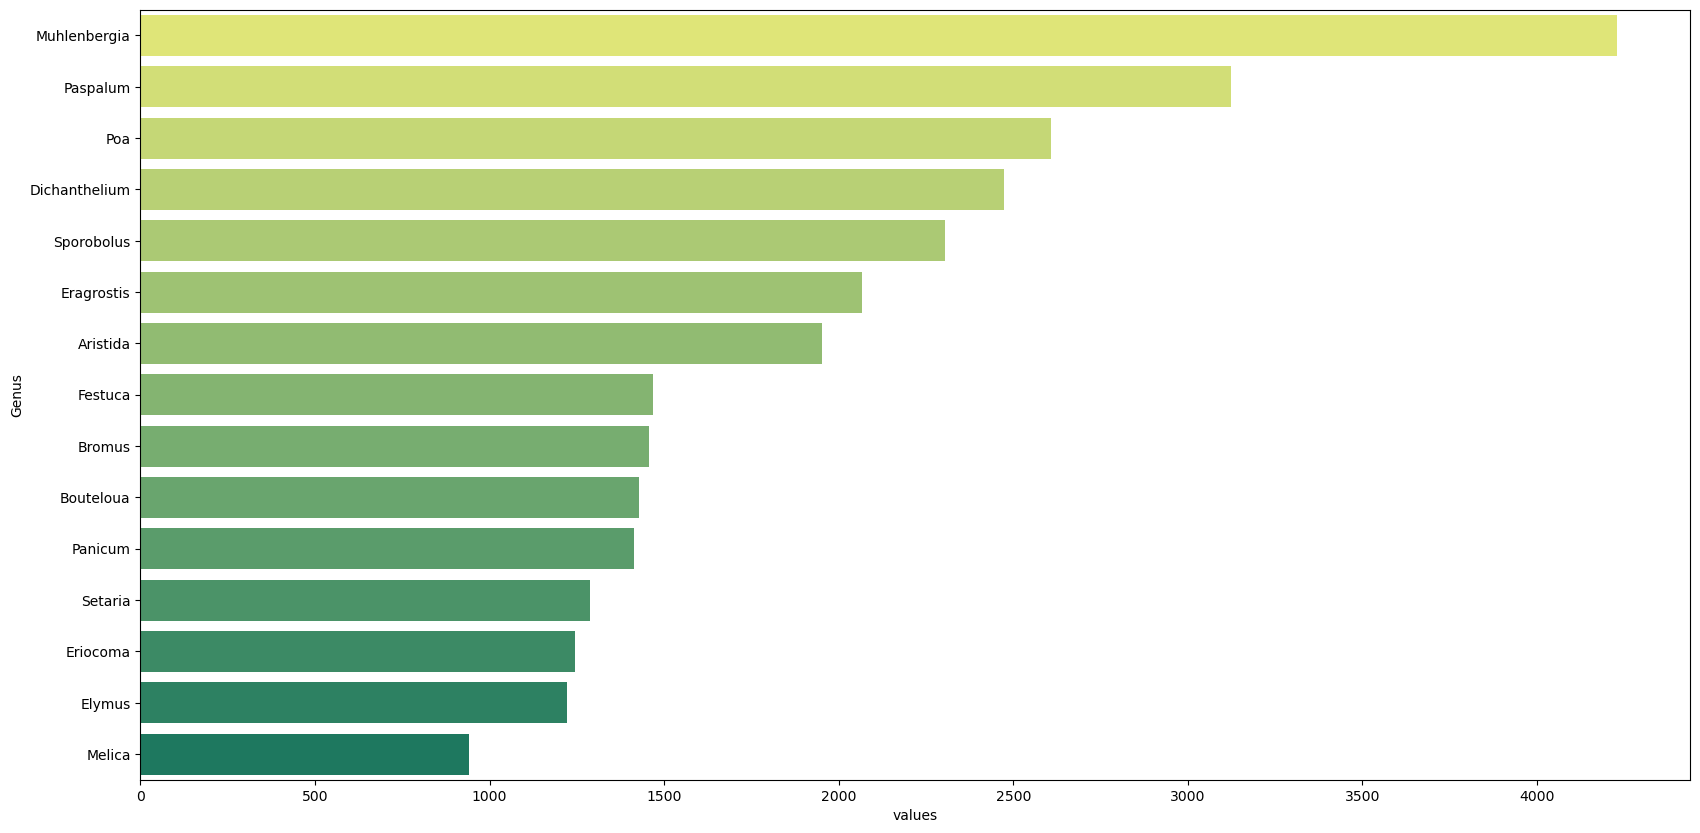

In [8]:
data = grass_images['genus'].value_counts().head(15)
data = pd.DataFrame({'Genus' : data.index,
                     'values' : data.values})

plt.figure(figsize = (20, 10))
sns.barplot(x='values', y = 'Genus', data = data , palette='summer_r')
plt.show()

# Image displaying

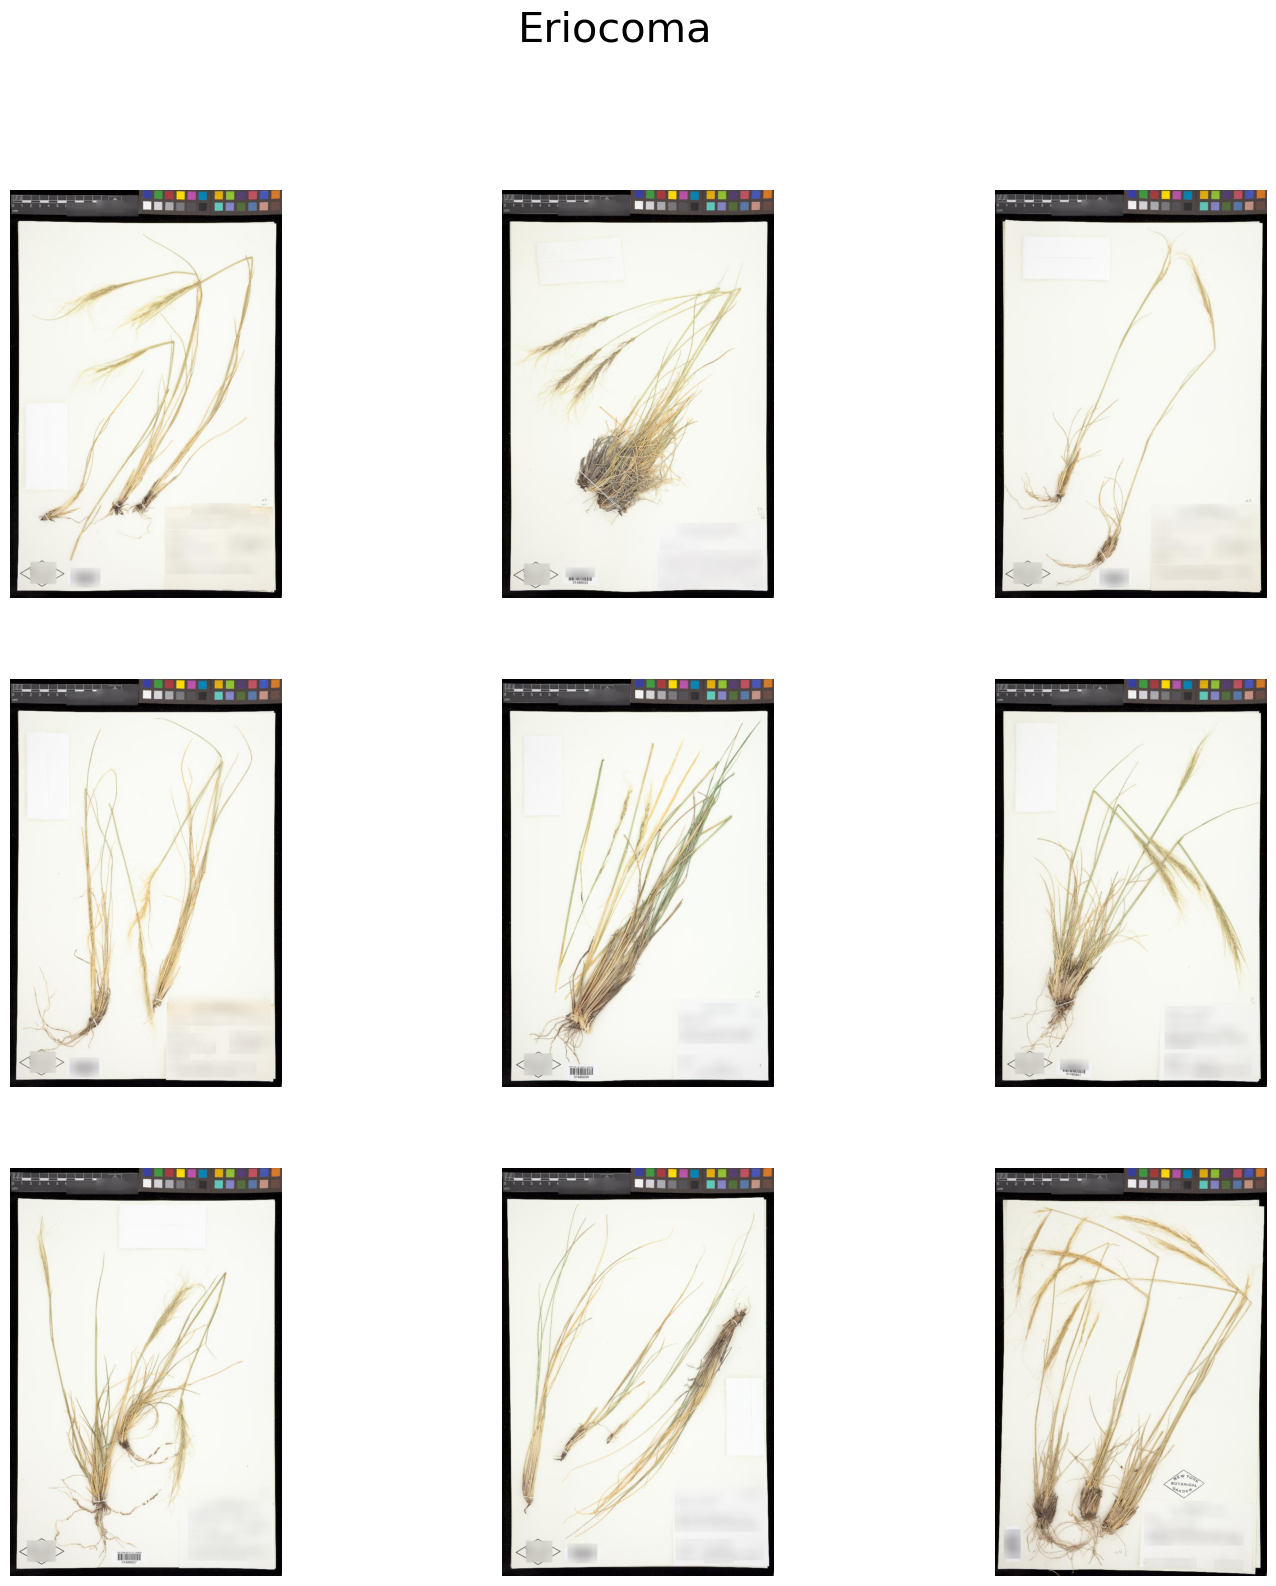

In [10]:
def show_images(genus):
    images = grass_images.loc[grass_images['genus'] == genus]['image_dir'][:9]
    i = 1
    fig = plt.figure(figsize = (18, 18))
    plt.suptitle(genus, fontsize = '30')
    for image in images:
        img = cv2.imread(image)
        ax = fig.add_subplot(3, 3, i)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_axis_off()
        i += 1
    plt.show()
show_images('Eriocoma')